# Final Project


### Our goal is to replicate the results in the paper: Quantifying Fiscal Multipliers in New Zealand: the Evidence from SVAR Models, by Anna Hamer-Adams and Martin Wong.<br><br>However, we use a different identification scheme to test whether and how the results are affected by this different methodology

#### We start by importing the packages and functions that we will need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from pandas_datareader.data import DataReader 
from scipy import signal
from numpy import linalg as LA
from scipy.optimize import root
%matplotlib inline

#### Now, we import the data. We have the original data used by the authors in an excel file, and we will use pandas to create a dataframe

In [2]:
df = pd.read_excel('Data Project.xlsx', index_col=0, parse_dates=True)

In [3]:
df

,G,NT,Y,DP,I
DATE,,,,,
1990-07-01,-0.725721,0.098405,2.075329,0.009991,0.142879
1990-10-01,-0.852352,0.103060,2.091817,0.010791,0.138444
1991-01-01,-0.743720,0.075223,2.054770,0.006228,0.120922
1991-04-01,-0.887704,0.027803,2.042473,0.000884,0.104248
1991-07-01,-1.149231,-0.049311,2.049949,0.003534,0.093297
...,...,...,...,...,...
2016-10-01,-0.088609,0.963686,2.522910,0.004136,0.020846
2017-01-01,-0.151277,0.975417,2.519845,0.009885,0.019930
2017-04-01,-0.068217,1.001268,2.530826,0.000000,0.019663


## Let's take a look at the data

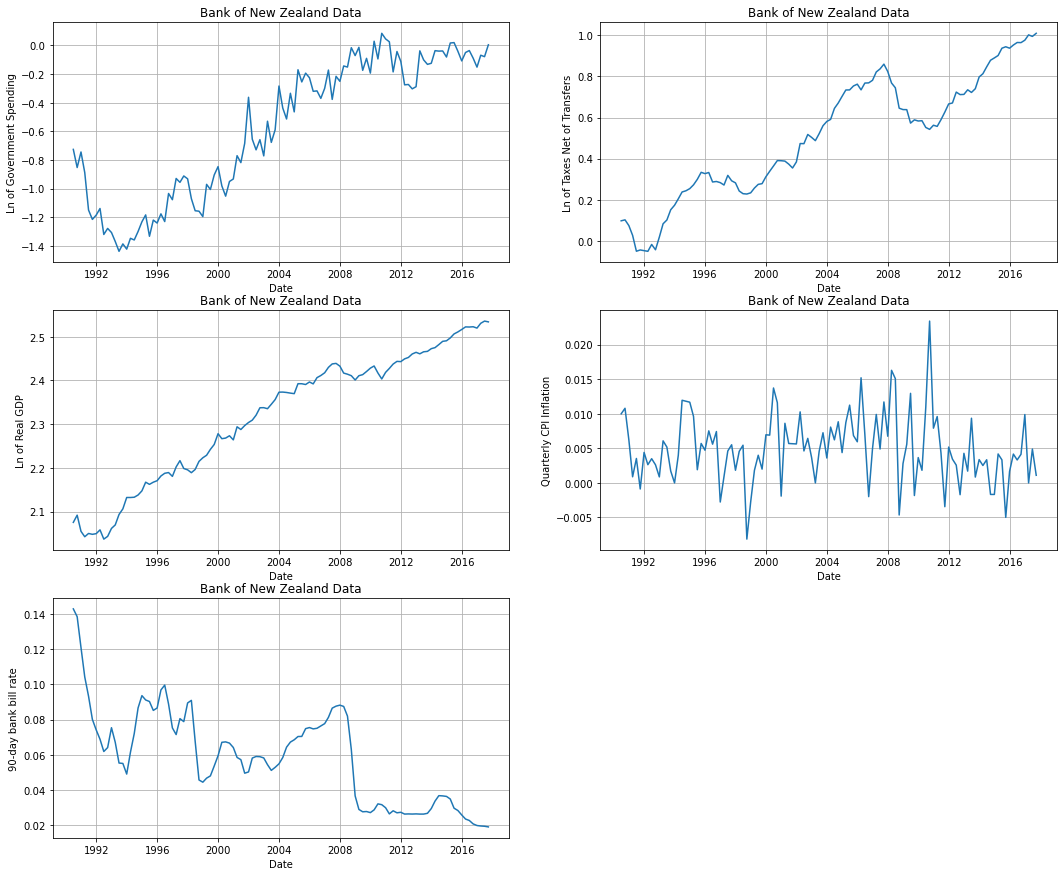

In [4]:
plt.figure(figsize=(18,15))
plt.subplot(321)
plt.plot(df["G"])
plt.xlabel('Date')
plt.ylabel('Ln of Government Spending')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(322)
plt.plot(df["NT"])
plt.xlabel('Date')
plt.ylabel('Ln of Taxes Net of Transfers')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(323)
plt.plot(df["Y"])
plt.xlabel('Date')
plt.ylabel('Ln of Real GDP')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(324)
plt.plot(df["DP"])
plt.xlabel('Date')
plt.ylabel('Quarterly CPI Inflation')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.subplot(325)
plt.plot(df["I"])
plt.xlabel('Date')
plt.ylabel('90-day bank bill rate')
plt.title('Bank of New Zealand Data')
plt.grid()
plt.show()

## We have the data, now we need to define a class, so that it can estimate the parameters of the model with our data, identify the structural shocks and create impulse response functions.

In [14]:
class SVAR():
    def __init__(self, X, lags=3, num_impulses = 10):  
        self.X = X
        self.num_vars = X.shape[1]
        self.lags = lags                 # In the paper, they define the model with 3 lags and 10 periods for the impulse response horizons.
        self.num_impulses = num_impulses # So we set these values as default, but create the attributes in case we want to test different specifications
        
    def Xlags(self):  # We need to create a dataframe with lags of our variables to use as dependent variables in the VAR model.
        XLAG = pd.DataFrame()
        for l in range(1,self.lags+1):
            XLAG = pd.concat([XLAG, self.X.shift(l).add_suffix("-"+str(l))], axis=1)
        X_avlb_dta = X.iloc[self.lags:,:]
        XLAG_avlb_dta = XLAG.iloc[self.lags:,:]  # Now we need to exclude from X and XLAG the observations where we have no data available for the lags.
        Xa = np.array(X_avlb_dta)                # And transform them in arrays so later we can perform math/algebra operations with them
        XLAGa = np.array(XLAG_avlb_dta)
        return Xa, XLAGa
    
    def ols_fit(self):   # Here, we use ols to estimate our VAR (reduced form) and recover the coefficients, rediduals and the error variance-covariance matrix
        Xa, XLAGa = self.Xlags()
        Bhat = inv(XLAGa.T@XLAGa)@XLAGa.T@Xa
        U = (Xa-XLAGa@Bhat)
        Ωhat = U.T@U
        return Bhat, U, Ωhat
    
    def identification(self):
        _, U, Ωhat = self.ols_fit()
        C = LA.cholesky(Ωhat)  # Use a cholesky decomposition to obtain a matrix that will be used to identify the structural shocks
        d = np.zeros(C.shape)  # Normalizing the matrix C
        np.fill_diagonal(d, np.diag(C))
        C = np.dot(np.linalg.inv(d), C)
        Ε = U @ inv(C).T   #Multiplying reduced form shocks by inv(C) to obtain the structural shocks Ε.
        return C, Ε
    
    def IRF(self):
        Bhat, _, _ = self.ols_fit()
        C, _ = self.identification()
        c_Bhat = np.vstack((Bhat.T,np.hstack((np.identity((self.lags-1)*self.num_vars), # Create a canonical form of Bhat to work as this was a VAR(1) (easier to represent as MA)
                                      np.zeros([(self.lags-1)*self.num_vars,self.num_vars]))))) 
        IRF  = np.zeros([self.num_impulses,self.num_vars,self.num_vars])
        Temp = np.identity(c_Bhat.shape[0]) # Initialize an array to store the IRF and a temp matrix, that represents the coefficients of the reduced form moving average
        for t in range(self.num_impulses):
            ψ_t = Temp[:self.num_vars,:self.num_vars] 
            IRF[t,:,:] = ψ_t @ C # Multiply the coefficients of the reduced form MA by C to obtain the coefficients of the structural form, which gives us our impulse response functions
            Temp = c_Bhat @ Temp # Update Temp to give us this sequence: (I, c_Bhat, (c_Bhat)^2, (c_Bhat)^3,...)
        irf  = pd.DataFrame({i:IRF[i].flatten() for i in range(self.num_impulses)}).T #save IRFs into a dataframe, flattening to two dimensions.
        irf.columns = ["Ε_G>G","Ε_NT>G","Ε_Y>G","Ε_CPI>G","Ε_IR>G","Ε_G>NT","Ε_NT>NT","Ε_Y>NT","Ε_CPI>NT","Ε_IR>NT","Ε_G>Y","Ε_NT>Y","Ε_Y>Y","Ε_CPI>Y","Ε_IR>Y","Ε_G>CPI","Ε_NT>CPI","Ε_Y>CPI","Ε_CPI>CPI","Ε_IR>CPI","Ε_G>IR","Ε_NT>IR","Ε_Y>IR","Ε_CPI>IR","Ε_IR>IR"]
        return c_Bhat, irf
    

In [15]:
X = df.copy()

In [16]:
Model1 = SVAR(X)

In [17]:
Bhat, U, Ωhat = Model1.ols_fit()

In [18]:
C, Ε = Model1.identification()

In [19]:
C

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.03077145,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.17403758,  0.32638868,  1.        ,  0.        ,  0.        ],
       [ 0.07502869,  0.0124087 , -0.07451658,  1.        ,  0.        ],
       [ 0.08545541,  0.23985958, -0.11102742,  0.14626007,  1.        ]])

In [20]:
_, irf = Model1.IRF()

In [21]:
irf

,Ε_G>G,Ε_NT>G,Ε_Y>G,Ε_CPI>G,Ε_IR>G,Ε_G>NT,Ε_NT>NT,Ε_Y>NT,Ε_CPI>NT,Ε_IR>NT,...,Ε_G>CPI,Ε_NT>CPI,Ε_Y>CPI,Ε_CPI>CPI,Ε_IR>CPI,Ε_G>IR,Ε_NT>IR,Ε_Y>IR,Ε_CPI>IR,Ε_IR>IR
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.030771,1.000000,0.000000,0.000000,0.000000,...,0.075029,0.012409,-0.074517,1.000000,0.000000,0.085455,0.239860,-0.111027,0.146260,1.000000
1,0.365215,-1.081092,-1.188791,1.534720,-0.644405,0.125847,1.195148,0.591889,0.064114,0.002649,...,0.030072,0.042395,-0.127572,0.130709,0.347401,0.145829,0.380900,-0.167955,0.385849,1.444183
2,0.531839,-0.636002,0.069430,1.401053,-1.252043,0.126472,1.451709,1.004337,-0.502050,0.077874,...,0.018783,0.043561,-0.058899,0.037068,0.178439,0.128418,0.410078,-0.206143,0.351534,1.307128
3,0.284622,-0.845292,-0.470966,1.874140,-2.472286,0.107943,1.325024,1.050588,0.085644,-0.719595,...,0.006442,0.014666,-0.001988,0.083879,-0.013321,0.102469,0.382830,-0.127607,0.279741,1.005697
4,0.100188,-0.770778,-0.197813,0.652587,-3.011462,0.034131,1.117171,1.073474,0.024840,-1.368902,...,-0.002029,0.008380,0.020119,-0.017464,-0.032254,0.088544,0.358962,-0.029060,0.226712,0.820130
5,0.059207,-0.587119,0.285008,0.394795,-3.460384,-0.007124,0.909862,1.184598,-0.083246,-1.886554,...,-0.001830,0.003459,0.016408,-0.002183,-0.027271,0.076862,0.325894,0.000534,0.219045,0.702584
6,-0.024013,-0.483283,0.474957,0.099522,-3.838134,-0.056860,0.672959,1.213951,-0.135806,-2.378267,...,-0.001043,0.001389,0.008863,0.008372,-0.015699,0.062697,0.282359,-0.004559,0.209544,0.592605
7,-0.098022,-0.415630,0.627670,-0.194866,-4.242017,-0.110895,0.429030,1.204589,-0.253764,-2.837834,...,-0.001313,-0.000276,0.003678,0.000732,-0.010982,0.050154,0.238493,-0.000384,0.180093,0.488653
8,-0.149957,-0.375169,0.804567,-0.362662,-4.614428,-0.157156,0.201080,1.195754,-0.375266,-3.225922,...,-0.001754,-0.002380,0.003336,-0.002826,-0.014094,0.039305,0.196941,0.008839,0.144481,0.397015
9,-0.193771,-0.355821,0.954197,-0.535917,-4.916255,-0.192672,0.002934,1.184123,-0.489263,-3.511933,...,-0.001782,-0.003552,0.004781,-0.004858,-0.015820,0.029555,0.157492,0.012946,0.113740,0.318147


 ## Now that we have our impulse response functions, we can plot them

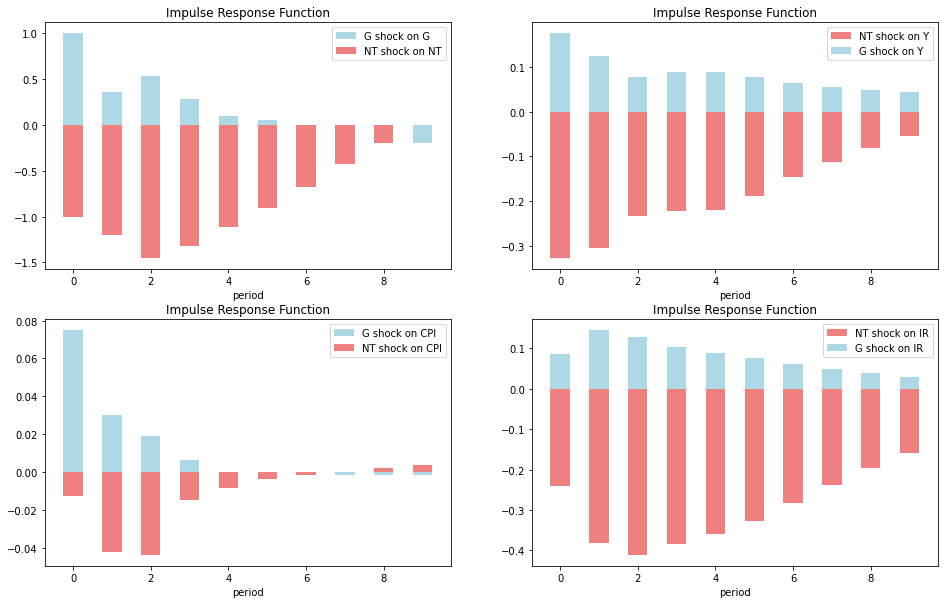

In [22]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.bar(irf.index, irf["Ε_G>G"], label='G shock on G', color = 'lightblue',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(221)
plt.bar(irf.index, irf["Ε_NT>NT"]*-1, label='NT shock on NT', color = 'lightcoral',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(222)
plt.bar(irf.index, irf["Ε_NT>Y"]*-1, label='NT shock on Y', color = 'lightcoral',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(222)
plt.bar(irf.index, irf["Ε_G>Y"], label='G shock on Y', color = 'lightblue',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(223)
plt.bar(irf.index, irf["Ε_G>CPI"], label='G shock on CPI', color = 'lightblue',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(223)
plt.bar(irf.index, irf["Ε_NT>CPI"]*-1, label='NT shock on CPI', color = 'lightcoral',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(224)
plt.bar(irf.index, irf["Ε_NT>IR"]*-1, label='NT shock on IR', color = 'lightcoral',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.subplot(224)
plt.bar(irf.index, irf["Ε_G>IR"], label='G shock on IR', color = 'lightblue',width=0.5)
plt.legend()
plt.xlabel('period')
plt.title('Impulse Response Function')
plt.grid()
plt.show()